In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Input

Read.csv file of one TF or multiple TF. If the .csv file contains multiple TF a line in the data importation column has to be uncommented.

# Output

The file contains a data preprocessing step as well as a pipeline to apply linear/ridge regression. It can either give back the feature with the smallest mean absolute value as well as the corresponding coefficients, R^2-value and the degree of the polynomial feature expansion.
If save = True it additionally saves the plots in a .pdf format.

# 1. Data importation

In [2]:
TF = 'C7'
#adapt filepath if it's different
df = pd.read_csv ('../Features/TF1_'+TF+'.csv',index_col = 0)
ypet_intensity = df.copy()
#If file contains multiple TFs uncomment next line and add TF_name to analyze:
#ypet_intensity[ypet_intensity['TF_name'] == 'TF name of TF we are interested in']

Save = False #Will try to save it the conditions are suitable

ypet_intensity.head()

,patch,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
0,patch_6,1,C - 7,False,False,557,790.666068,440401,790.0,56.209692,...,0.006944,0.259459,0.167568,0.094595,0.102703,0.064865,0.083784,0.089189,0.137838,0.726082
1,patch_7,1,C - 7,False,False,739,1042.802436,770631,926.0,274.833903,...,0.046875,0.208835,0.178715,0.102410,0.128514,0.076305,0.078313,0.076305,0.150602,0.794946
2,patch_8,1,C - 7,False,False,680,841.535294,572244,831.0,89.429541,...,0.064338,0.247140,0.178490,0.091533,0.112128,0.089245,0.082380,0.064073,0.135011,0.853092
3,patch_9,1,C - 7,False,False,1234,870.455429,1074142,845.0,117.994204,...,0.004808,0.200000,0.201220,0.097561,0.100000,0.091463,0.080488,0.069512,0.159756,0.812795
4,patch_11,1,C - 7,False,False,1106,828.970163,916841,829.0,56.703426,...,0.019817,0.234890,0.192308,0.093407,0.081044,0.057692,0.086538,0.076923,0.177198,0.880464


# 2. Preprocessing

## Parameters to adapt for the data processing

In [3]:
#parameters to adapt for analyzation:
#outlier removal
outlier = False #If outliers in general should be removed True, if not False

if outlier == False: 
    outlier_columns = ['patch_size','mean_intensity','median_intensity','sum_intensity'] #choose columns of which the outliers should be removed. to choose all the columns: list(ypet_intensity_processed)[6:]
    quantile_keep = 1 # Quantile we want to keep. For removal: 0.85 we keep 85%
    interquantile = True #if outliers should be removed by defining a range with the interquantile: True; to remove outliers just when they're exceeding a certain quantile: False   
    outlier_range = 0.7 #if interquantile = True defined this value to define the range. Gets multiplicated with interquantile, else ignore


#Z-Normalization
normalization = False# True
columns_to_be_normalized =  ['patch_size','mean_intensity','median_intensity','sum_intensity'] #list(ypet_intensity_processed)[6:]  #if all columns should be normalized

#Log-Transformation
take_log = False #want to take the log of certain columns
columns_log = ['patch_size','mean_intensity','median_intensity','sum_intensity'] #needs pre-analyzation of columns if log is needed. With a histogram it can be seen if the distribution is skewed. 

# Blur removal
remove_blur_lapl = False # Laplacian filter
remove_blur_lapl_threshold = 10000 # Values above this threshold are removed

remove_blur_ski = True # perceptual blur
remove_blur_ski_threshold = 0.8 # Values above this threshold are removed

# Removal based on similarity
remove_similarity = False
similarity_threshold = 0.5 # Values below this threshold are removed

ypet_intensity_processed = ypet_intensity.copy()



## Similarity removal

In [4]:
if remove_similarity == True:
        remove_boolean = ypet_intensity_processed.similarity > similarity_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]

## Blur removal

In [5]:
if remove_blur_lapl == True:
        remove_boolean = ypet_intensity_processed.blur_lapl < remove_blur_lapl_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]
        
if remove_blur_ski == True:
        remove_boolean = ypet_intensity_processed.blur_ski < remove_blur_ski_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]

## Outlier removal of predefined columns of the dataframe

In [6]:
def outlier_removal(without_outliers, **kwargs):
    #define input parameters
    outlier_columns = kwargs['outlier_columns'] 
    interquantile =   kwargs['interquantile']
    quantile_keep =   kwargs['quantile_keep']

    # first choose which method for outlier removal wants to be used. Use a for loop to iterate over the defined columns of the dataframe.
    if interquantile == True:
        outlier_range =   kwargs['outlier_range']
        for col in outlier_columns:
            # defined the interquantile range and then the upper and lower limit of the choosen column
            median = without_outliers[col].median()
            q_75 = without_outliers[col].quantile(q = 0.75)
            q_25 = without_outliers[col].quantile(q = 0.25)
            interquantile = q_75 - q_25                              
            upper_bound = median + (interquantile * outlier_range)
            lower_bound = median - (interquantile * outlier_range)

            # Create a boolean mask that is True for rows with a value less than or equal to the upper limit and higher or equal to the lower limit
            mask = (without_outliers[col] <= upper_bound) & (without_outliers[col] >= lower_bound)
            # Use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    if interquantile == False: 
        
        for col in outlier_columns:
            #define the limit up to which the values are kept
            quantile_limit = without_outliers[col].quantile(q = 1)
            #define a boolean mask that is True for rows that are in the defined limit
            mask = without_outliers[col] < quantile_limit
            #use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    
        
    return without_outliers


In [7]:
#apply the function for outlier removal
if outlier == True:
    #group by the TF and just cut the outliers for one TF
    without_outliers = ypet_intensity_processed.groupby('TF_name',as_index=False).apply(outlier_removal, outlier_range=outlier_range, outlier_columns=outlier_columns, interquantile = interquantile, quantile_keep=quantile_keep).reset_index()
    #change index so dataframe is as before
    without_outliers = without_outliers.drop(['level_0'],axis=1)
    without_outliers = without_outliers.set_index('level_1')
    without_outliers.index.name = None
    #save it under a new dataframe
    ypet_intensity_processed = without_outliers.copy()

## Log-Transformation

In [8]:
#take logs of predefined columns that are skewed:
if take_log == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    log_rows = TF_grouped[columns_log].transform(lambda x: np.log(x))
    ypet_intensity_processed[columns_log] = log_rows 

## Normalization of columns of the dataframe

In [9]:
# Normalization of columns of the dataframe
if normalization == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    Normalized_columns = TF_grouped[columns_to_be_normalized].transform(lambda x: (x - x.mean()) / x.std()) #removed rows_to_be to have all col normalized

    # Replace normalized
    ypet_intensity_processed[columns_to_be_normalized] = Normalized_columns                         


# Task_1

## 2. Data exploration

### Scatterplots between patch_size and similarity, mean_intensity, median_intensity, sum_intensity

Scatterplots:
- for regression line set degree to 1
- If other features should be shown: change features for the plots

In [10]:
Save = False

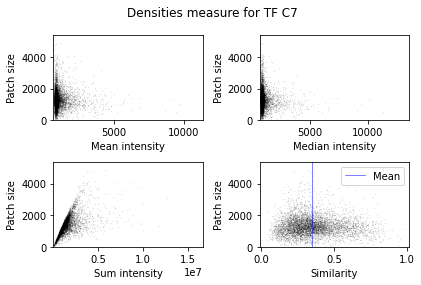

In [11]:
mk_size = 0.01 #Choose a small mk_size if a lot of datapoints, so densities are easier to read
points_col = 'black'
line_col   = 'blue'

plt.figure()
plt.subplot(221)
sns.regplot(y="patch_size", x="mean_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Mean intensity"); plt.ylabel("Patch size")
plt.xlim(ypet_intensity_processed.mean_intensity.min(),ypet_intensity_processed.mean_intensity.max())
plt.ylim(0,ypet_intensity_processed.patch_size.max())
plt.subplot(222)
sns.regplot(y="patch_size", x="median_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Median intensity"); plt.ylabel("Patch size")
plt.xlim(ypet_intensity_processed.median_intensity.min(),ypet_intensity_processed.median_intensity.max())
plt.ylim(0,ypet_intensity_processed.patch_size.max())
plt.subplot(223)
sns.regplot(y="patch_size", x="sum_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Sum intensity"); plt.ylabel("Patch size")
plt.xlim(ypet_intensity_processed.sum_intensity.min(),ypet_intensity_processed.sum_intensity.max())
plt.ylim(0,ypet_intensity_processed.patch_size.max())
plt.subplot(224)
sns.regplot(y="patch_size", x="similarity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.xlabel("Similarity"); plt.ylabel("Patch size")
plt.axvline(np.mean(ypet_intensity_processed['similarity']),color = line_col,linewidth = 0.5,label = "Mean")
plt.ylim(0,ypet_intensity_processed.patch_size.max())
plt.legend()
plt.suptitle("Densities measure for TF "+TF)#+", outlier range = 1.5 w.r.t. sum intensity")
plt.tight_layout()
if Save:
    plt.savefig("../Images/task1/densities_"+TF+".pdf")
plt.savefig('outlier_cut_interquartile', dpi = 300)
plt.show()

## 3. 2D-Regression: Choose the feature that has the smallest absolute value

This part chooses the best feature with the smallest absolute value by applying a cross validation both for the least squares and for the ridge regression.

### Parameters to adapt:

In [12]:
maxdegree = 10                          #To define is the maximum degree of the polynomial that should be tried (maxdegree of 5 takes degree up to 4 into account)
alphas = [1e-4,1e-3, 1e-2, 1e-1, 1]     #Alpha grid for ridge regression
K = 10                                  #Number of fold for the cross validation
x_features = ['mean_intensity','median_intensity'] #add features for x for which the best model have to be find
decide_y_feature = 'patch_size' #decide y-feature
mode_error = mean_absolute_error #mean_absolute_error # mean_squared_error # mean_absolute_error


In [13]:
#define a test and a training set
df_train, df_test = train_test_split(ypet_intensity_processed, train_size = 0.8, test_size = 0.2, random_state = 10)

In [14]:
mae_test_lm_list = []
mae_test_ridge_list = []
R2_lm_list = []
R2_ridge_list = []
degree_min_lm = []
degree_min_ridge = [] 

if mode_error == mean_squared_error:
    error_cv = 'neg_mean_squared_error'
    print('yes')
else:
    error_cv = 'neg_mean_absolute_error'

for feature in x_features: 

    # Prepare test and train sets and X and y------------------------
    #Define features used with the right format, following x_features and decide_x_features
    features_used = [feature]

    #define the x and the y for the test and train sets
    df_train_x = df_train[features_used]
    df_test_x = df_test[features_used]

    df_train_y = df_train[[decide_y_feature]]
    df_test_y = df_test[[decide_y_feature]]

    # Apply cross validation ----------------------------------------------
    #model to select
    cross_validation_ridge_error = np.zeros(maxdegree)
    cross_validation_lm_error = np.zeros(maxdegree)

    #see which degree fits data the best for linear regression
    for d in range(1, maxdegree+1):    #it will create 1,2...maxdregree range vector like this
        #polynomial feature expansion of x_train
        x_poly_train = PolynomialFeatures(degree=d).fit_transform(df_train_x)
        #apply linear regression model and cross-validation for alpha-ridge regression
        lr = LinearRegression()
        rr = RidgeCV(alphas=alphas)
        #apply cross validation
        cve = cross_validate(lr,x_poly_train,df_train_y,scoring= error_cv, cv=K, return_train_score=True)
        crr = cross_validate(rr,x_poly_train,df_train_y,scoring= error_cv, cv=K, return_train_score=True)
        #make array for cross validation with linear model and for ridge regression
        cross_validation_lm_error[d-1] = np.mean(np.absolute(cve['test_score']))
        cross_validation_ridge_error[d-1] = np.mean(np.absolute(crr['test_score']))

    # Compute MAE for both model ----------------------
    index_min_lm = np.argmin(cross_validation_lm_error)
    index_min_ridge = np.argmin(cross_validation_ridge_error)

    poly_lm_test = PolynomialFeatures(degree=index_min_lm+1)
    x_poly_test_lm = poly_lm_test.fit_transform(df_test_x)
    poly_lm_train = PolynomialFeatures(degree=index_min_lm+1)
    x_poly_train_lm = poly_lm_train.fit_transform(df_train_x)

    x_poly_train_df_lm = pd.DataFrame(x_poly_train_lm)
    x_poly_test_df_lm = pd.DataFrame(x_poly_test_lm)

    poly_ridge_test = PolynomialFeatures(degree=index_min_ridge+1)
    x_poly_test_ridge = poly_ridge_test.fit_transform(df_test_x)
    poly_ridge_train = PolynomialFeatures(degree=index_min_ridge+1)
    x_poly_train_ridge = poly_ridge_train.fit_transform(df_train_x)

    x_poly_train_df_ridge = pd.DataFrame(x_poly_train_ridge)
    x_poly_test_df_ridge = pd.DataFrame(x_poly_test_ridge)

    #make linear model/ridge regression
    model_lm = LinearRegression().fit(x_poly_train_df_lm, df_train_y)
    model_ridge = RidgeCV(alphas=[1e-4,1e-3, 1e-2, 1e-1, 1]).fit(x_poly_train_df_ridge, df_train_y)

    #train error
    y_train_pred_lm = model_lm.predict(x_poly_train_lm)
    mse_train_lm = mode_error(df_train_y,y_train_pred_lm)
    y_train_pred_ridge = model_ridge.predict(x_poly_train_ridge)
    mse_train_ridge = mode_error(df_train_y,y_train_pred_ridge)
    
    #test error
    y_test_pred_lm = model_lm.predict(x_poly_test_df_lm)
    mae_test_lm = mode_error(df_test_y,y_test_pred_lm)
    y_test_pred_ridge = model_ridge.predict(x_poly_test_df_ridge)
    mae_test_ridge = mode_error(df_test_y,y_test_pred_ridge)

    # R2 score
    r2_score_ridge = r2_score(df_test_y,y_test_pred_ridge)
    r2_score_lm = r2_score(df_test_y,y_test_pred_lm)
    
    # append
    mae_test_lm_list.append(mae_test_lm)
    mae_test_ridge_list.append(mae_test_ridge)
    R2_lm_list.append(r2_score_lm)
    R2_ridge_list.append(r2_score_ridge)
    degree_min_lm.append(index_min_lm + 1)
    degree_min_ridge.append(index_min_ridge + 1)

In [15]:
if min(mae_test_ridge_list) < min(mae_test_lm_list):
    min_index = mae_test_ridge_list.index(min(mae_test_ridge_list))
    print('Best model: Ridge Regression',round(mae_test_lm_list[min_index],3),'R2', R2_ridge_list[min_index] )
    print('Polynomial degree', degree_min_ridge[min_index])
else: 
    min_index = mae_test_lm_list.index(min(mae_test_lm_list))
    print('Best model: Least squares', round(mae_test_lm_list[min_index],3),'R2', R2_lm_list[min_index] )
    print('Polynomial degree:', degree_min_lm[min_index])
print('Best feature:', x_features[min_index])

Best model: Least squares 431.494 R2 -0.0013412815708517822
Polynomial degree: 3
Best feature: mean_intensity


# 4. Regression (2D or ND) of predefined features

This part computes a least squares or ridge regression for predefined feature. It uses cross-validation to determine the degree for the polynomial feature expansion that minimizes the mean absolute value.

### Parameters to adapt:

In [16]:
x_features = ['mean_intensity','sum_intensity','similarity','median_intensity'] #define a list with all the columns that could be interesting for task 1
decide_x_features = np.array([1])      #set the list of indexes for the X values used for regression from list defined in x_features
decide_y_feature = 'patch_size'        #also other features could be taken into account
mode_error = mean_absolute_error #mean_absolute_error # mean_squared_error # mean_absolute_error


In [17]:
#Define features used with the right format, following x_features and decide_x_features
features_used = [x_features[i] for i in decide_x_features]
# Split in train and test set -- CAREFUL: defines other train/test set than above, can lead to slightly different results
df_train, df_test = train_test_split(ypet_intensity_processed, train_size = 0.8, test_size = 0.2, random_state = 10)

#define the x and the y for the test and train sets
df_train_x = df_train[features_used]
df_test_x = df_test[features_used]
df_train_y = df_train[[decide_y_feature]]
df_test_y = df_test[[decide_y_feature]]

In [18]:
#model to select
cross_validation_ridge_error = np.zeros(maxdegree)
cross_validation_lm_error = np.zeros(maxdegree)

#see which degree fits data the best for linear regression
for d in range(1, maxdegree+1):    #it will create 1,2...maxdregree range vector like this
    #polynomial feature expansion of x_train
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(df_train_x)
    #apply linear regression model and cross-validation for alpha-ridge regression
    lr = LinearRegression()
    rr = RidgeCV(alphas=alphas)
    #apply cross validation
    cve = cross_validate(lr,x_poly_train,df_train_y,scoring= error_cv, cv=K, return_train_score=True)
    crr = cross_validate(rr,x_poly_train,df_train_y,scoring=error_cv, cv=K, return_train_score=True)
    #make array for cross validation with linear model and for ridge regression
    cross_validation_lm_error[d-1] = np.mean(np.absolute(cve['test_score']))
    cross_validation_ridge_error[d-1] = np.mean(np.absolute(crr['test_score']))

In [19]:
index_min_lm = np.argmin(cross_validation_lm_error)
index_min_ridge = np.argmin(cross_validation_ridge_error)

poly_lm_test = PolynomialFeatures(degree=index_min_lm+1)
x_poly_test_lm = poly_lm_test.fit_transform(df_test_x)
poly_lm_train = PolynomialFeatures(degree=index_min_lm+1)
x_poly_train_lm = poly_lm_train.fit_transform(df_train_x)

x_poly_train_df_lm = pd.DataFrame(x_poly_train_lm)
x_poly_test_df_lm = pd.DataFrame(x_poly_test_lm)

poly_ridge_test = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_test_ridge = poly_ridge_test.fit_transform(df_test_x)
poly_ridge_train = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_train_ridge = poly_ridge_train.fit_transform(df_train_x)

x_poly_train_df_ridge = pd.DataFrame(x_poly_train_ridge)
x_poly_test_df_ridge = pd.DataFrame(x_poly_test_ridge)

#make linear model
model_lm = LinearRegression().fit(x_poly_train_df_lm, df_train_y)
model_ridge = RidgeCV(alphas=[1e-4,1e-3, 1e-2, 1e-1, 1]).fit(x_poly_train_df_ridge, df_train_y)

#train error
y_train_pred_lm = model_lm.predict(x_poly_train_lm)
mse_train_lm = mode_error(df_train_y,y_train_pred_lm)
y_train_pred_ridge = model_ridge.predict(x_poly_train_ridge)
mse_train_ridge = mode_error(df_train_y,y_train_pred_ridge) 

#test error
y_test_pred_lm = model_lm.predict(x_poly_test_df_lm)
mae_test_lm = mode_error(df_test_y,y_test_pred_lm)
y_test_pred_ridge = model_ridge.predict(x_poly_test_df_ridge)
mae_test_ridge = mode_error(df_test_y,y_test_pred_ridge)

### Parameters for the best model 

In [20]:
if mae_test_ridge >= mae_test_lm:
    feature_names = poly_lm_test.get_feature_names_out(input_features=features_used)
    print('take linear regression')
    print('features: ',feature_names)
    print('coefficients: ',model_lm.coef_) 
    print('intercept: ',model_lm.intercept_)
    print('R^2-score: ', r2_score(df_test_y,y_test_pred_lm))
    print('Mean absolute test error:', round(mae_test_lm,3))

else:
    feature_names = poly_ridge_test.get_feature_names_out(input_features=features_used)
    print('take ridge regression')
    print('features: ',feature_names)
    print('coefficients: ',model_ridge.coef_)
    print('intercept: ',model_ridge.intercept_)
    print('alpha: ',model_ridge.alpha_)
    print('R^2-score: ', r2_score(df_test_y,y_test_pred_ridge))
    print('Mean absolute test error:', round(mae_test_ridge,3))

take linear regression
features:  ['1' 'sum_intensity' 'sum_intensity^2' 'sum_intensity^3']
coefficients:  [[ 0.00000000e+00  1.07978078e-03 -1.66722695e-10  6.72205347e-18]]
intercept:  [189.06072834]
R^2-score:  0.5670236889862685
Mean absolute test error: 258.866


### Visualize the best model

The visualization part is just possible, when X contains just one feature.

In [21]:
Save = True

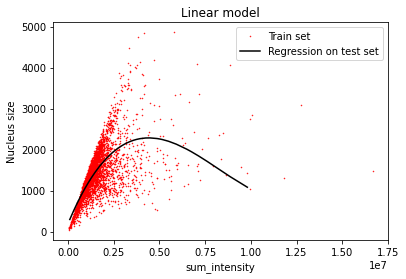

In [22]:
#show predicted points with linear model
df_plot_sort = pd.DataFrame(df_test_x)
df_plot_sort['reg'] =  y_test_pred_lm[:,0]
df_plot_sort.sort_values(features_used[0],inplace = True)

#show predicted points with linear model

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort[features_used[0]],df_plot_sort['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Linear model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    if Save:
        plt.savefig("../Images/task1/linear_model_"+features_used[0]+"_"+TF+".pdf") 
    plt.show()

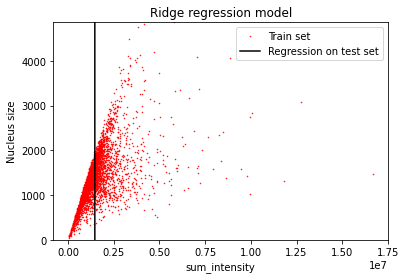

In [23]:
#show predicted points with ridge model
df_plot_sort_ridge = pd.DataFrame(df_test_x)
df_plot_sort_ridge['reg'] =  y_test_pred_ridge[:,0]
df_plot_sort_ridge.sort_values(features_used[0],inplace = True)

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort_ridge[features_used[0]],df_plot_sort_ridge['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.ylim(0,df_train_y.patch_size.max())
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Ridge regression model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    if Save:
        plt.savefig("../Images/task1/ridge_model_"+features_used[0]+"_"+TF+".pdf")
    plt.show()
#plt.savefig('ridge_original', dpi = 300)